###**03.평균이동**

**평균 이동(Mean Shlft)의 개요**

- K- 평균과 유사하게 중심을 군집의 중심으로 지속적으로 움직이며 군집화를 수행
- 중심을 데이터가 모여있는 밀도가 가장 높은 곳으로 이동시키는 특징을 가짐
- 데이터 분포도를 이용하여 군집의 중심점을 찾음
  - 군집 중심점: 데이터 포인트가 모여있는 곳으로 확률 밀도 함수를 기반하여 나타남
  - 이러한 확률밀도함수를 찾기 위해 KDE를 이용
- 포인트를 이동시키기 위해 주변 데이터와의 거리값을 KDE함수값으로 입력하고 그 반환값을 업데이트 하여 이동함

  -> 반복적 수행

**KDE함수**
- 커널 함수를 통해 어떤 변수의 확률 밀도를 추정하는 대표적 방법
- 관측된 데이터 각각의 커널 함수를 적용한 값을 모두 더하고 데이터 건수로 나눠 추정
- 가우시안 분포 함수가 커널 함수로 사용됨
  - 대역폭 h: KDE 형태를 부드러운 형태로 평활화하는데 적용
  - 확률 밀도 추정 성능을 크게 좌우
  - 작은 h값은 과적합의 원인이 되기도 하며, 그렇다고 지나치게 큰 h값은 과도한 단순화를 일으킴
  - estimater_bandwidth()로 수행

In [8]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X,y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


In [9]:
meanshift = MeanShift(bandwidth=2)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


In [10]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.816


In [11]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

#estimater_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


<ipython-input-12-e1250fcb1cba>:18: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker=''% label) # 나타나지 않아 코드 변경


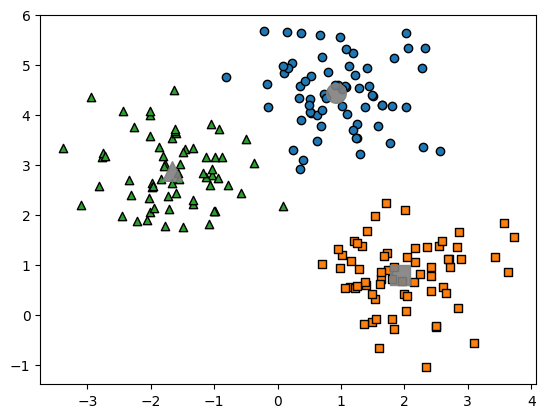

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
  label_cluster = clusterDF[clusterDF['meanshift_label']==label]
  center_x_y = centers[label]

  #군집별로 다른 마커로 산점도 적용
  plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])

  #군집별로 중심 표현
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker=''% label) # 나타나지 않아 코드 변경

plt.show()

In [13]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


###**04. GMM(Gaussian Mixture Model)**

**GMM 소개**
- 군집화를 적용하고자 하는 데이터가 여러 개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정하에 군집화를 수행하는 방식
  - 가우시안 분포: 좌우 대칭형의 종(Bell) 모양의 연속확률함수
  - 정규 분포: 평균 mu를 중심으로 높은 데이터 분포도를 가지고 있음
- 전체 데이터 세트는 서로 다른 정규분포 형태를 가진 여러 가지 확률 분포 곡성으로 구성될 수 있기에 이러한 다른 정규분포에 기반하여 군집화를 수행하는 방식이 GMM을 의미함
- 데이터가 특정 정규분포에 해당될 확률을 구하는 것을 모수 추정이라 하는데 가우시안 분포는 이 모수추정을 수행
  - 개별 정규 분포의 평균과 분산
  - 각 데이터가 어떤 정규 분포에 해당되는지의 확룰


**GMM을 이용한 붓꿏 데이터 세트 군집화**
- 붓꽃 데이터 세트로 이 두 가지 방식을 이용해 군집화를 수행한 뒤 양쪽 방식을 비교

In [14]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# 좀더 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [15]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 군집화 결과를 irisDF의 'gmm_cluster'칼럼명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target

# target값에 따라 gmm_cluster값이 어떻게 매핑 됐는지 확인.
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       1              50
1       0              45
        2               5
2       2              50
Name: count, dtype: int64


In [16]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       0                 47
        2                  3
2       2                 36
        0                 14
Name: count, dtype: int64


**GMM과 K-평균 비교**

K-means
- 원형의 범위에서 군집화를 수행하고, 이 범위를 가지면 군집화 효율이 더욱 높아짐
- 데이터가 원형의 범위로 퍼져 있지 않으면 군집화를 잘 수행하지 못함

GMM
- K-means모다 유연하게 다양한 데이터 세트에 잘 적용될 수 있으나 수행시간이 오래걸린다는 단점이 존재

In [17]:
def visualize_cluster_plot(kmeans_model, cluster_data, target_name, iscenter=True):
    if iscenter :
        centers = kmeans_model.cluster_centers_

    unique_labels = np.unique(cluster_data[target_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = cluster_data[cluster_data[target_name]==label]
        if isNoise:
            marker = 'x'
        else:
            marker = markers[label % len(markers)]

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k',
                    marker=marker)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white',
                        alpha=0.9, edgecolor='k', marker=marker)
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='black',
                        edgecolor='k', marker='' % label)

    if iscenter:
        plt.title(f'Clustering results with {kmeans_model.__class__.__name__} centers')
    else:
        plt.title('Data distribution by target')
    plt.show()

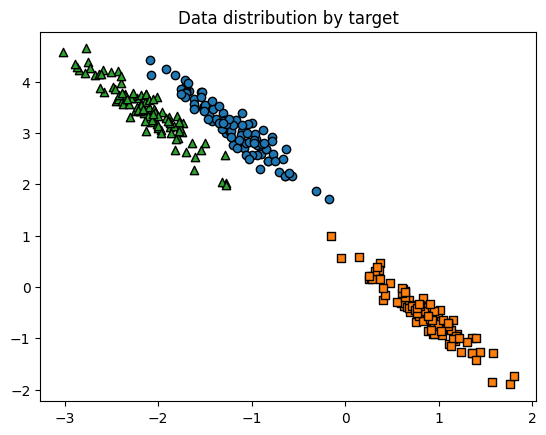

In [22]:
from sklearn.datasets import make_blobs

# make_blobs()로 300개의 데이터 세트, 3개의 군집 세트, cluster_std = 0.5를 만듦
X, y= make_blobs(n_samples=300, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 세트를 생성하기 위해 변환함.
transformation = [[0.60834549,-0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
# feature 데이터 세트와 make_blobs()의 y 결괏값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
# 생성된 데이터 세트를 target별로 다른 마커로 표시해 시각화함
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

<ipython-input-17-4fcaa97898cb>:23: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='black',


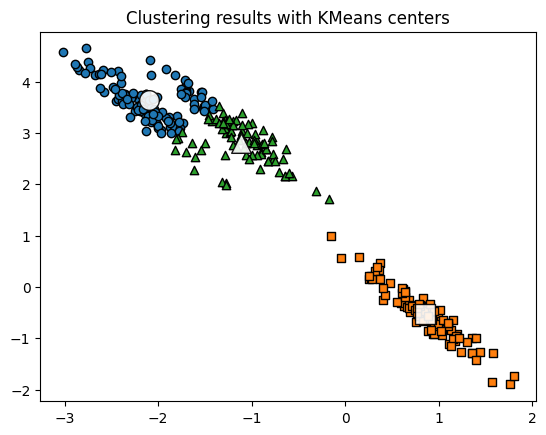

In [23]:
# 3개의 군집 기반 Kmeans를 X_aniso 데이터 세트에 적용
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

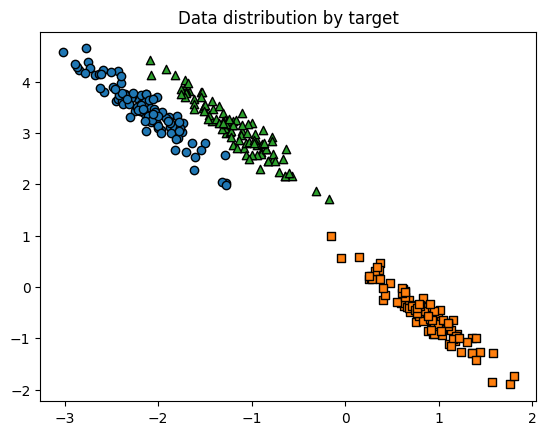

In [24]:
#3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용
gmm=GaussianMixture(n_components=3, random_state=0)
gmm_label=gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label']=gmm_label

#GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정
visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscenter=False)

In [25]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64
